In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import plot_roc_curve, auc, roc_curve, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

## Prepare Data

In [44]:
# read in dataframe
data = pd.read_csv("../data/binarized_data.csv", dtype={"Sex":str})
# randomly shuffle rows
data = data.sample(frac=1)
# onehotencode gender feature
data["Sex"] = data["Sex"].map({"m":0, "f":1})
# view data shape
print("Data Shape:", data.shape)
# drop nans + view data shape after dropping NaNs
data = data.dropna(how="any")
print("Data Shape:", data.shape)
# store target
y = data["Category"].values
# store features
x = data.values[:,1:] # remove target column (first column)

Data Shape: (615, 13)
Data Shape: (589, 13)


## Evaluate Model w/out Cross Validation

The max_iter was reached which means the coef_ did not converge


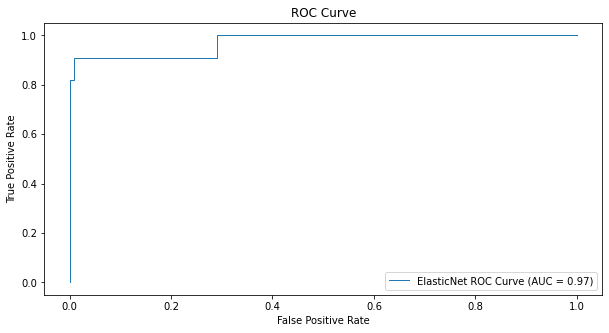

In [164]:
random_state=777
# split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
# define elasticnet classifier
classifier = LogisticRegression(penalty="elasticnet", random_state=random_state, solver="saga", l1_ratio=.5, n_jobs=-1)
# fit classifier
classifier.fit(X_train, y_train)
# plot resultant roc curve
fig, ax = plt.subplots(figsize=(10,5))
ax.title.set_text("ROC Curve")
plot_roc_curve(classifier, X_test, y_test, name='ElasticNet ROC Curve', lw=1, ax=ax)
plt.show()


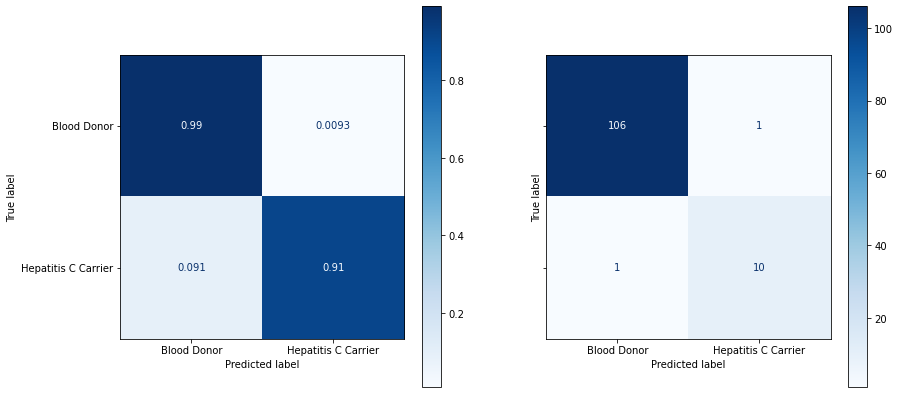

In [165]:
# plot normalized vs. unnormalized confusion matrices
display_labels = ["Blood Donor", "Hepatitis C Carrier"]
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row', gridspec_kw={'hspace': .2, 'wspace': .2}, figsize=(14,7))
(ax1, ax2) = axs
plot_confusion_matrix(classifier, X_test, y_test, display_labels=display_labels,cmap=plt.cm.Blues,normalize="true", ax=ax1)
plot_confusion_matrix(classifier, X_test, y_test, display_labels=display_labels,cmap=plt.cm.Blues,normalize=None, ax=ax2)
disp.ax_.set_title("Confusion Matrix")
plt.show()

## Evaluate Model w/ 9-Fold Cross Validation

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


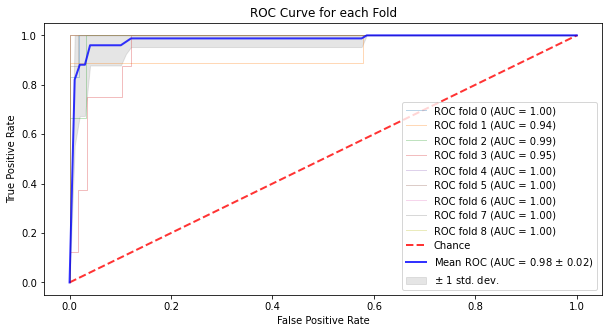

In [126]:
random_state=777
# define 9 folds
kf = KFold(n_splits=9)
kf.get_n_splits(x)
KFold(n_splits=10, random_state=None, shuffle=False)
classifier = LogisticRegression(penalty="elasticnet", random_state=random_state, solver="saga", l1_ratio=.5, n_jobs=-1)
tprs = []
aucs = []
cminfo = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10,5))
for i, (train, test) in enumerate(kf.split(x, y)):
    X_train, X_test = x[train], x[test]
    y_train, y_test = y[train], y[test]
    classifier.fit(X_train, y_train)
    cminfo.append((classifier, X_test, y_test)) # save CM info to generate CMS for each fold
    viz = plot_roc_curve(classifier, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Curve for each Fold")
ax.legend(loc="lower right")
plt.show()

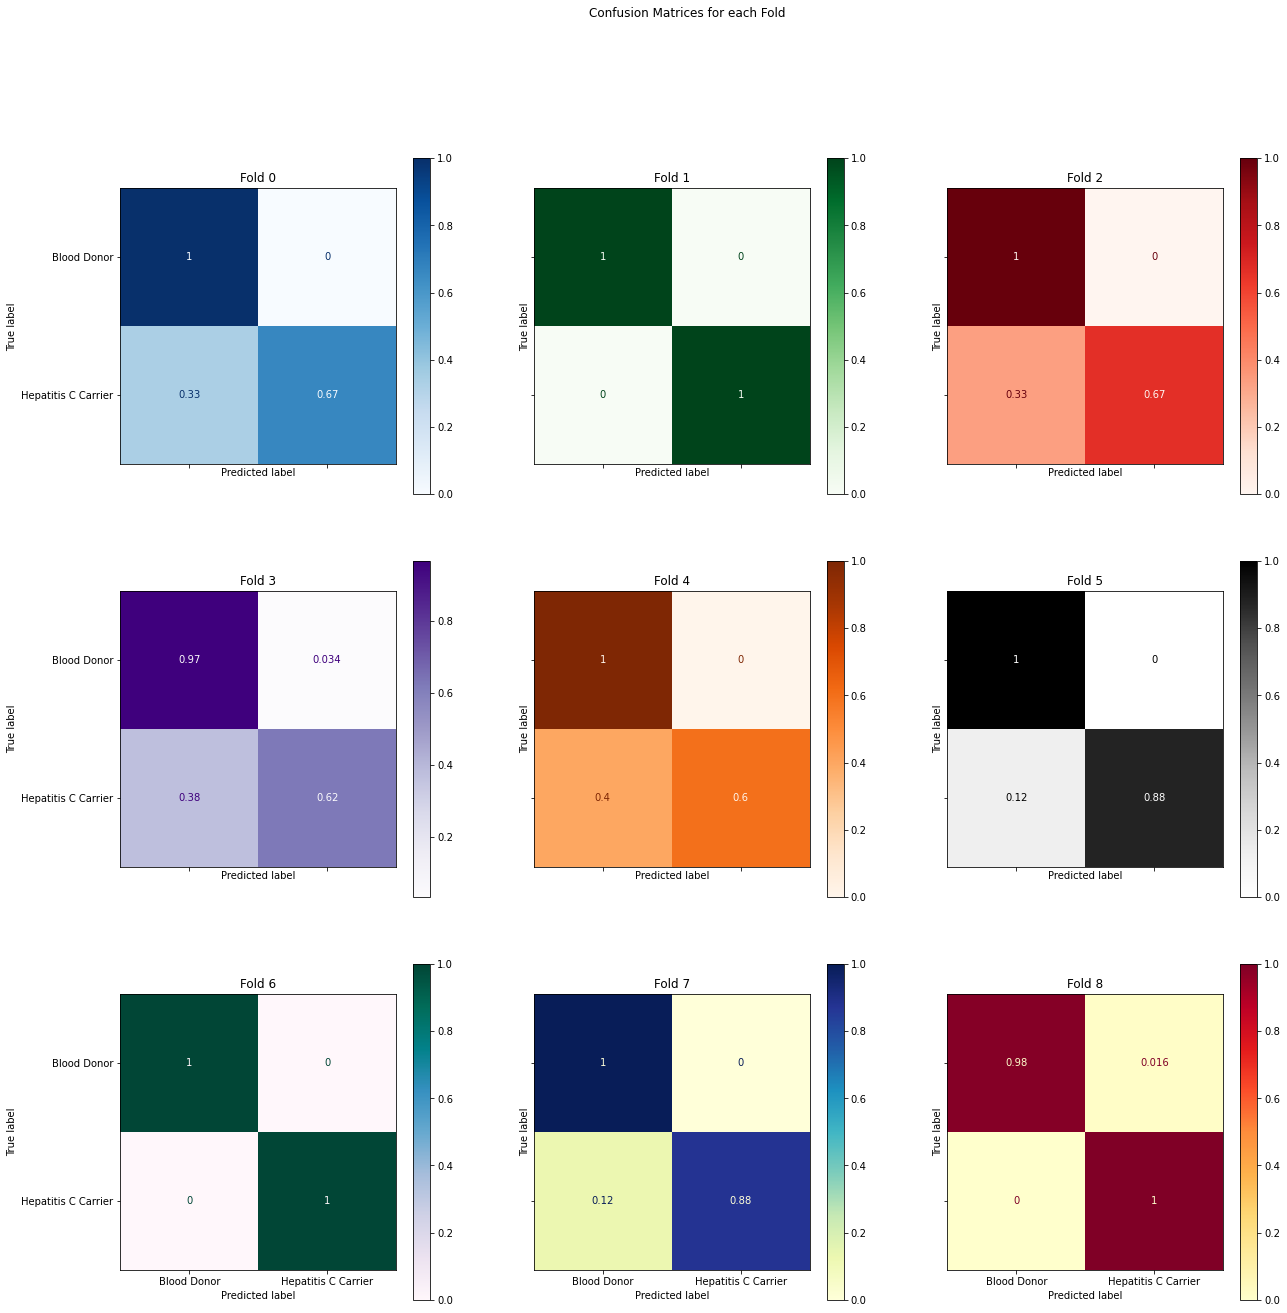

In [152]:
display_labels = ["Blood Donor", "Hepatitis C Carrier"]
fig, axs = plt.subplots(3, 3, sharex='col', sharey='row', gridspec_kw={'hspace': .2, 'wspace': .2}, figsize=(21,21))
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs
fig.suptitle("Confusion Matrices for each Fold")
ax1.title.set_text("Fold 0")
ax2.title.set_text("Fold 1")
ax3.title.set_text("Fold 2")
ax4.title.set_text("Fold 3")
ax5.title.set_text("Fold 4")
ax6.title.set_text("Fold 5")
ax7.title.set_text("Fold 6")
ax8.title.set_text("Fold 7")
ax9.title.set_text("Fold 8")
plot_confusion_matrix(cminfo[0][0], cminfo[0][1], cminfo[0][2],display_labels=display_labels,cmap=plt.cm.Blues,normalize="true", ax=ax1)
plot_confusion_matrix(cminfo[1][0], cminfo[1][1], cminfo[1][2],display_labels=display_labels,cmap=plt.cm.Greens,normalize="true", ax=ax2)
plot_confusion_matrix(cminfo[2][0], cminfo[2][1], cminfo[2][2],display_labels=display_labels,cmap=plt.cm.Reds,normalize="true", ax=ax3)
plot_confusion_matrix(cminfo[3][0], cminfo[3][1], cminfo[3][2],display_labels=display_labels,cmap=plt.cm.Purples,normalize="true", ax=ax4)
plot_confusion_matrix(cminfo[4][0], cminfo[4][1], cminfo[4][2],display_labels=display_labels,cmap=plt.cm.Oranges,normalize="true", ax=ax5)
plot_confusion_matrix(cminfo[5][0], cminfo[5][1], cminfo[5][2],display_labels=display_labels,cmap=plt.cm.Greys,normalize="true", ax=ax6)
plot_confusion_matrix(cminfo[6][0], cminfo[6][1], cminfo[6][2],display_labels=display_labels,cmap=plt.cm.PuBuGn,normalize="true", ax=ax7)
plot_confusion_matrix(cminfo[7][0], cminfo[7][1], cminfo[7][2],display_labels=display_labels,cmap=plt.cm.YlGnBu,normalize="true", ax=ax8)
plot_confusion_matrix(cminfo[8][0], cminfo[8][1], cminfo[8][2],display_labels=display_labels,cmap=plt.cm.YlOrRd,normalize="true", ax=ax9)
plt.show()